In [1]:
import pandas as pd
import cobra
import sys
sys.path.append('/home/hvdinh16/Workspace/workpy3/common/')
from custom_functions import *

In [2]:
df_in = pd.read_excel('./input/rxn_details.xlsx')
df_in.index = df_in.rxn.to_list()

In [3]:
model = cobra.io.load_json_model('../build_GAMS_model/input/GSM_iSace1144_rba.json')
model.solver = 'cplex'

# Valid turnoff (cycling)
model.reactions.LACPYRt_c_m.knock_out()

# Turn off due to regulation
# Ethanol utilization enzyme expression is repressed under glucose-utilizing condition (pmid:3290644)
model.reactions.ALCD2i1_c.knock_out()
# Ethanol-acetaldehyde shuttle only active under anaerobic condition (pmid:10940011)
model.reactions.ALCD2i2_m.knock_out()
# Totally unrelated reactions that form transhydrogenase cycle
model.reactions.get_by_id('4ABTORy_c').knock_out()
model.reactions.get_by_id('4ABTORx_c').knock_out()
# Disable FADH2 transport across mitochondrial membrane. Enable this creating fumarate-succinate shuttle that enables proton gradient generation
model.reactions.get_by_id('FADH2t_c_m').knock_out()
model.reactions.get_by_id('ICDHy_c').knock_out()
# Disable glycolysis bypass via methylglyoxal (disable lactate transport to mito)
model.reactions.get_by_id('LACtps_m').knock_out()

# Turn off alternative unparameterized pathways (which is cheaper to operate since unparameterized pathways used median kapp)
model.reactions.get_by_id('G3PAT_l').knock_out()
model.reactions.get_by_id('AGPAT_l').knock_out()
model.reactions.get_by_id('PAP_vm').knock_out()
model.reactions.get_by_id('PAP_gm').knock_out()
model.reactions.get_by_id('DHAPAT_rm').knock_out()
model.reactions.get_by_id('DHAPAT_l').knock_out()
model.reactions.get_by_id('G3PD1i_m').knock_out()

# YNB media
model.reactions.get_by_id('EX_thm_e').lower_bound = -1000
model.reactions.get_by_id('EX_ribflv_e').lower_bound = -1000
model.reactions.get_by_id('EX_nac_e').lower_bound = -1000
model.reactions.get_by_id('EX_pydxn_e').lower_bound = -1000
model.reactions.get_by_id('EX_fol_e').lower_bound = -1000
model.reactions.get_by_id('EX_pnto__R_e').lower_bound = -1000
model.reactions.get_by_id('EX_4abz_e').lower_bound = -1000
model.reactions.get_by_id('EX_inost_e').lower_bound = -1000


--------------------------------------------
--------------------------------------------

Using license file /home/hvdinh16/Workspace/Softwares/gurobi910/linux64/gurobi.lic
Academic license - for non-commercial use only - expires 2022-08-08


In [4]:
rxns = [rxn.id for rxn in model.reactions]

In [5]:
with model as m:
    m.reactions.EX_glc__D_e.lower_bound = -13.2
    m.reactions.BIOMASS_AERO_SC_hvd.bounds = (0.4236, 0.4236)
    m.reactions.ATPM_c.lower_bound = 1
    
    m.objective = dict()
    fva = cobra.flux_analysis.flux_variability_analysis(m, reaction_list=rxns)

In [6]:
rxns = df_in.index.to_list()

In [7]:
cols =['rxn', 'name', 'subsystem', 'rba_min', 'rba_max', 'fva_min', 'fva_max']
df_res = pd.DataFrame(columns=cols, index=rxns)

df_res['rxn'] = df_in['rxn']
df_res['name'] = df_in['name']
df_res['subsystem'] = df_in['subsystem']

for rxn in df_res.index:
    df_res.loc[rxn, 'fva_min'] = fva.minimum[rxn]
    df_res.loc[rxn, 'fva_max'] = fva.maximum[rxn]

In [8]:
with open('./vary_flux_fragments_minflux/minflux.txt') as f:
    text = f.read().split('\n')[:-1]
rbamin = dict()
for line in text:
    _,rxn,stat,val = line.split('\t')
    if stat == 'optimal':
        rbamin[rxn] = float(val)
    else:
        print('Something wrong with ' + rxn + ', stat = ' + stat)
        
with open('./vary_flux_fragments_maxflux/maxflux.txt') as f:
    text = f.read().split('\n')[:-1]
rbamax = dict()
for line in text:
    _,rxn,stat,val = line.split('\t')
    if stat == 'optimal':
        rbamax[rxn] = float(val)
    else:
        print('Something wrong with ' + rxn + ', stat = ' + stat)
        
for rxn in df_res.index:
    df_res.loc[rxn, 'rba_min'] = rbamin[rxn]
    df_res.loc[rxn, 'rba_max'] = rbamax[rxn]

In [9]:
# Save raw FVA RBA output
df_res.to_excel('./results/FVA_RBA_bounds.xlsx', index=None)

In [10]:
# Remove pseudoreaction
df_res = df_res[df_res.subsystem != 'Pseudoreaction']
df_res = df_res[df_res.subsystem != 'Transport']
df_res = df_res[df_res.subsystem != 'Exchange']

# Handle reversible rxns with non-zero reverse flux
df_res = df_res[(df_res.fva_max > 0) | (df_res.fva_min < 0)]

idx_remove = []
for rxn in df_res.index:
    fvamin = df_res.fva_min[rxn]
    fvamax = df_res.fva_max[rxn]
    rbamin = df_res.rba_min[rxn]
    rbamax = df_res.rba_max[rxn]
    
    rfwd = rxn + '_FWD'
    rrev = rxn + '_REV'
    if fvamin < 0:
        idx_remove.append(rxn)
        
        df_res.loc[rrev, 'fva_min'] = 0
        df_res.loc[rrev, 'fva_max'] = abs(fvamin)
        df_res.loc[rrev, 'rba_min'] = 0
        df_res.loc[rrev, 'rba_max'] = abs(rbamin)
        df_res.loc[rrev, 'rxn'] = rrev
        df_res.loc[rrev, 'name'] = df_res.name[rxn]
        df_res.loc[rrev, 'subsystem'] = df_res.subsystem[rxn]
        
        if fvamax > 0:
            df_res.loc[rfwd, 'fva_min'] = 0
            df_res.loc[rfwd, 'fva_max'] = fvamax
            df_res.loc[rfwd, 'rba_min'] = 0
            df_res.loc[rfwd, 'rba_max'] = rbamax
            df_res.loc[rfwd, 'rxn'] = rfwd
            df_res.loc[rfwd, 'name'] = df_res.name[rxn]
            df_res.loc[rfwd, 'subsystem'] = df_res.subsystem[rxn]

In [11]:
# Save processed FVA RBA results
idx_remove_checked = [i for i in idx_remove if i in df_res.index]
df_res = df_res.drop(index=idx_remove_checked, axis=0)
df_res.to_excel('./results/FVA_RBA_bounds_processed.xlsx', index=None)

In [13]:
model.reactions.ACCOAC_c.subsystem

'Fatty acid biosynthesis'

In [12]:
df = df_res[df_res.fva_max > 0]
ratio_dict = pd.core.series.Series(dtype='float64')
for rxn in df.index:
    ratio_dict[rxn] = df.rba_max[rxn] / df.fva_max[rxn]

In [15]:
for i in ratio_dict[ratio_dict > 1].index:
    if '_FWD' in i or '_REV' in i:
        eqn = model.reactions.get_by_id(i[:-4]).reaction
    else:
        eqn = model.reactions.get_by_id(i).reaction
        
    print(i, eqn, ratio_dict[i])

3HAO_c 3hanthrn_c + o2_c --> cmusa_c + h_c 1.300840991083594
AFAT_c atp_c + fmn_c + h_c --> fad_c + ppi_c 191.7752596789424
AHMMPS4_c air_c + nadh_c --> 4ahmmp_c + gcald_c + nad_c + pi_c 1352.7856468366385
ALAS_m gly_m + h_m + succoa_m --> 5aop_m + co2_m + coa_m 765.1764636449482
ALATRS_c ala__L_c + atp_c + trnaala_c --> alatrna_c + amp_c + ppi_c 1.2563823797599791
ARGTRS_c arg__L_c + atp_c + trnaarg_c --> amp_c + argtrna_c + ppi_c 1.7600634795160275
ASNTRS_c asn__L_c + atp_c + trnaasn_c --> amp_c + asntrna_c + ppi_c 1.5982543666130715
ASPTRS_c asp__L_c + atp_c + trnaasp_c --> amp_c + asptrna_c + ppi_c 1.5909311296336273
CPPPGO_c cpppg3_c + 2.0 h_c + o2_c --> 2.0 co2_c + 2.0 h2o_c + pppg9_c 756.7516525023608
CYSTRS_c atp_c + cys__L_c + trnacys_c --> amp_c + cystrna_c + ppi_c 26.90016868368376
DB4PS_c ru5p__D_c --> db4p_c + for_c + h_c 4.943744098205854
DHPPDA2_c 25dhtpp_c + h2o_c + h_c --> 5aprbu_c + nh4_c 4.943744098205854
DRAPPRy_c 25drapp_c + h_c + nadph_c --> 25dhtpp_c + nadp_c 4.9

In [18]:
df

,rxn,name,subsystem,rba_min,rba_max,fva_min,fva_max
13GS_c,13GS_c,"1,3-beta-glucan synthase",Starch and sucrose metabolism,0.278665,0.278665,0.410132,0.410132
16GS_c,16GS_c,"1,6-beta-glucan synthase",Cell wall biosynthesis,0.073333,0.073333,0.107929,0.107929
3DSPHR_r,3DSPHR_r,3-dehydrosphinganine reductase,Sphingolipid biosynthesis,0.001935,0.001935,0.002014,0.002014
3HACD200_rm,3HACD200_rm,B-hydroxyacyl-CoA dehydratase (trans-icos-2-en...,Fatty acid elongation,0.001935,0.274959,0.002014,3.891163
3HACD220_rm,3HACD220_rm,B-hydroxyacyl-CoA dehydratase (trans-docos-2-e...,Fatty acid elongation,0.001935,0.237695,0.002014,3.521647
...,...,...,...,...,...,...,...
TKT2_c_REV,TKT2_c_REV,transketolase 2,Pentose phosphate pathway,0,2.886051,0,7.609554
TKT2_c_FWD,TKT2_c_FWD,transketolase 2,Pentose phosphate pathway,0,4.235345,0,20.985162
TPI_c_REV,TPI_c_REV,triose-phosphate isomerase,Glycolysis / Gluconeogenesis,0,12.617514,0,56.110852
TPI_c_FWD,TPI_c_FWD,triose-phosphate isomerase,Glycolysis / Gluconeogenesis,0,12.265989,0,12.043327


In [17]:
rxns_check = ['HEX1_c_FWD', 'PGI_c_FWD', 'PFK_c_FWD', 'FBA_c_FWD']

In [ ]:
PGI_c_FWD g6p_c <=> f6p_c 1.0189178376498111
PGK_c_FWD 13dpg_c + adp_c <=> 3pg_c + atp_c 1.01592022287747
PGM_c_FWD 3pg_c <=> 2pg_c 1.0156825986943006
TPI_c_FWD dhap_c <=> g3p_c 1.0184883471349362
ENO_c_FWD 2pg_c <=> h2o_c + pep_c 1.0156825986942986
GAPD_c_FWD g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c 1.015836964193617


In [24]:
df_in.iloc[710]

rxn                           EX_mn2_e
name                   Mn(2+) exchange
subsystem                     Exchange
rxn_comp_fwd    RXN-EX_mn2_e_FWD-SPONT
rxn_comp_rev    RXN-EX_mn2_e_REV-SPONT
Name: EX_mn2_e, dtype: object

In [16]:
with model as m:
    m.reactions.EX_glc__D_e.lower_bound = -13.2
    m.reactions.BIOMASS_AERO_SC_hvd.bounds = (0.4236, 0.4236)
    m.reactions.ATPM_c.lower_bound = 1
    
    m.objective = dict()
    model.reactions.HEX1_c.objective_coefficient = 1
    
    fba = model.optimize()
make_escher_csv(fba, './test.escher.csv')

In [42]:
fba.objective_value

125.33620710110857

In [20]:
df_res.loc['FMNH_c_REV']

rxn                                       FMNH_c_REV
name         riboflavin-5-phosphate phosphohydrolase
subsystem                                 Unassigned
rba_min                                            0
rba_max                                         0.16
fva_min                                            0
fva_max                                     0.000004
Name: FMNH_c_REV, dtype: object

In [ ]:
DCYTD_c       14.128437
NDPK7_c        8.533462
NTD3pp_c      14.128437

In [17]:
model.reactions.get_by_id('3HPH5MBDC_m')

Reaction identifier,3HPH5MBDC_m
Name,3-hexaprenyl-4-hydroxy-5-methoxybenzoate decarboxylase
Memory address,0x07f8c378b31d0
Stoichiometry,3hph5mb_m + h_m --> 2hp6mp_m + co2_m 3-hexaprenyl-4-hydroxy-5-methoxybenzoic acid [mitochondrion] + H+ [mitochondrion] --> 2-hexaprenyl-6-methoxyphenol [mitochondrion] + carbon dioxide [mitochondrion]
GPR,YDR539W
Lower bound,0.0
Upper bound,1000.0


In [16]:
model.reactions.FLPT_c

Reaction identifier,FLPT_c
Name,flavin prenyltransferase
Memory address,0x07f8c36e24750
Stoichiometry,dmpp_c + fmnh2_c --> ppi_c + prefmn_c prenyl diphosphate(3-) [cytoplasm] + FMNH2 [cytoplasm] --> diphosphate [cytoplasm] + prenyl-FMN (cofactor)
GPR,YDR538W
Lower bound,0.0
Upper bound,1000.0


In [29]:
for rxn in ratio_dict.keys():
    if 'TRS_c' in rxn:
        print(rxn, ratio_dict[rxn])

ALATRS_c 1.2746614713912445
ARGTRS_c 1.7744541412878592
ASNTRS_c 1.6103579511705652
ASPTRS_c 1.6103579511705652
CYSTRS_c 26.68482658064902
GLNTRS_c 0.643589279908421
GLUTRS_c 1.045832579851184
GLYTRS_c 1.1907110106946694
HISTRS_c 3.548932533360063
ILETRS_c 1.7971841414407772
LEUTRS_c 1.399266262085929
LYSTRS_c 1.1373024536913756
METTRS_c 6.008305006906274
PHETRS_c 1.1592277630041377
PROTRS_c 1.0328720745027273
SERTRS_c 1.635533698594738
THRTRS_c 1.4532721621120537
TRPTRS_c 3.8318673183753327
TYRTRS_c 3.8122719856298697
VALTRS_c 0.8494845837236716


In [ ]:
ALATRS_c       1.274661
ARGTRS_c       1.774454
ASNTRS_c       1.610358
ASPTRS_c       1.610358
CYSTRS_c      26.684827
GLNTRS_c 0.643589279908421
GLUTRS_c       1.045833
GLYTRS_c       1.190711
HISTRS_c       3.548933
ILETRS_c       1.797184
LEUTRS_c       1.399266
LYSTRS_c       1.137302
METTRS_c       6.008305
PHETRS_c       1.159228
PROTRS_c       1.032872
SERTRS_c       1.635534
THRTRS_c       1.453272
TRPTRS_c       3.831867
TYRTRS_c       3.812272
VALTRS_c 0.8494845837236716

In [22]:
ratio_dict

13GS_c            0.682707
16GS_c            0.648572
1AGPCt_l_rm       0.014042
1AGPEt_l_rm       0.014042
2OBUTt_c_m        0.535964
                    ...   
compACYLCOA_l     0.014840
compACYLCOA_rm    0.015232
compCER_r         0.000000
lumpFACS160_c     0.147030
lumpFACS180_c     0.149159
Length: 1087, dtype: float64

In [12]:
ratios = [df.rba_max[i] / df.fva_max[i] for i in df.index]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

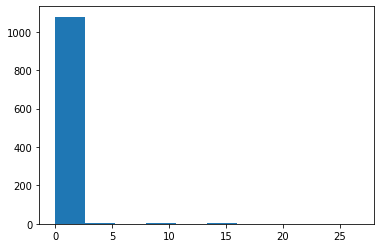

In [17]:
plt.hist(ratios);

In [41]:
rbamax

{'12AMANTF_g': 0.0,
 '13BDGLUCANt_c_en': 0.0,
 '13BGH_e': 0.0,
 '13GS_c': 0.28,
 '14BMANTF_c': 0.0,
 '14DMLANOSTt_c_e': 0.0,
 '16GS_c': 0.07,
 '1AGPCt_l_rm': 1.76,
 '1AGPEt_l_rm': 1.76,
 '1MLCLAT_mm': 0.0,
 '23CAPPD_c': 0.0,
 '2DDA7Pt_c_m': 0.0,
 '2DHPt_c_m': 0.0,
 '2HGOR_c': 0.0,
 '2MBACt_c_e': 0.0,
 '2MBALDt_c_e': 0.0,
 '2MBALDt_c_m': 0.0,
 '2MBTOHt_c_e': 0.0,
 '2MBTOHt_c_m': 0.0,
 '2OBUTt_c_m': 3.62,
 '2OXOADPt_c_m': 2.32,
 '2PHETOHt_c_e': 0.0,
 '2PHETOHt_c_m': 4.64,
 '3C3HMPt_c_e': 5.19,
 '3C3HMPt_c_m': 0.0,
 '3C4MOPt_c_m': 0.0,
 '3DH5HPBMT_m': 0.0,
 '3DH5HPBt_c_m': 0.0,
 '3DSPHR_r': 0.0,
 '3HACD200_rm': 0.27,
 '3HACD220_rm': 0.24,
 '3HACD240_rm': 0.21,
 '3HACD260_rm': 0.19,
 '3HAD40_m': 0.0,
 '3HAD60_m': 0.0,
 '3HAD80_m': 0.0,
 '3HAO_c': 0.0,
 '3HPH5MBDC_m': 0.0,
 '3HXPHBH_c': 0.0,
 '3HXPHBt_c_m': 0.0,
 '3IPM3MT_c': 0.0,
 '3MBALDt_c_e': 0.0,
 '3MBALDt_c_m': 0.0,
 '3MLCLAT_mm': 0.0,
 '3MOBDC_c': 4.69,
 '3MOPt_c_e': 0.0,
 '3MOPt_c_m': 13.23,
 '3OACE200_rm': 0.27,
 '3OACE220_rm': 0.2

In [39]:
rbamin

{'12AMANTF_g': 0.0,
 '13BDGLUCANt_c_en': 0.0,
 '13BGH_e': 0.0,
 '13GS_c': 0.28,
 '14BMANTF_c': 0.0,
 '14DMLANOSTt_c_e': -0.6,
 '16GS_c': 0.07,
 '1AGPCt_l_rm': 0.0,
 '1AGPEt_l_rm': -1.79,
 '1MLCLAT_mm': 0.0,
 '23CAPPD_c': 0.0,
 '2DDA7Pt_c_m': 0.0,
 '2DHPt_c_m': -2.15,
 '2HGOR_c': 0.0,
 '2MBACt_c_e': 0.0,
 '2MBALDt_c_e': 0.0,
 '2MBALDt_c_m': 0.0,
 '2MBTOHt_c_e': 0.0,
 '2MBTOHt_c_m': 0.0,
 '2OBUTt_c_m': 0.0,
 '2OXOADPt_c_m': 0.08,
 '2PHETOHt_c_e': -4.64,
 '2PHETOHt_c_m': 0.0,
 '3C3HMPt_c_e': 0.0,
 '3C3HMPt_c_m': -5.33,
 '3C4MOPt_c_m': 0.0,
 '3DH5HPBMT_m': 0.0,
 '3DH5HPBt_c_m': 0.0,
 '3DSPHR_r': 0.0,
 '3HACD200_rm': 0.0,
 '3HACD220_rm': 0.0,
 '3HACD240_rm': 0.0,
 '3HACD260_rm': 0.0,
 '3HAD40_m': 0.0,
 '3HAD60_m': 0.0,
 '3HAD80_m': 0.0,
 '3HAO_c': 0.0,
 '3HPH5MBDC_m': 0.0,
 '3HXPHBH_c': 0.0,
 '3HXPHBt_c_m': 0.0,
 '3IPM3MT_c': 0.0,
 '3MBALDt_c_e': 0.0,
 '3MBALDt_c_m': 0.0,
 '3MLCLAT_mm': 0.0,
 '3MOBDC_c': 0.0,
 '3MOPt_c_e': -3.48,
 '3MOPt_c_m': -3.62,
 '3OACE200_rm': 0.0,
 '3OACE220_rm': 0.0

In [37]:
text[-1]

'1887\tr_4324_m\toptimal\t0.0'

In [32]:
df_res

,rxn,name,subsystem,rba_min,rba_max,fva_min,fva_max
12AMANTF_g,NaN,NaN,NaN,NaN,NaN,0.0,0.0
13BDGLUCANt_c_en,NaN,NaN,NaN,NaN,NaN,0.0,0.0
13BGH_e,NaN,NaN,NaN,NaN,NaN,0.0,0.0
13GS_c,NaN,NaN,NaN,NaN,NaN,0.410132,0.410132
14BMANTF_c,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...
compFALPD_rm,NaN,NaN,NaN,NaN,NaN,-125.336983,0.0
lumpFACS160_c,NaN,NaN,NaN,NaN,NaN,0.048694,4.964972
lumpFACS180_c,NaN,NaN,NaN,NaN,NaN,0.01817,4.357759
r_4323_m,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [26]:
fva.shape[0]

1895

In [24]:
fva.head()

,minimum,maximum
RLFC2O_c,0.000000,59.557092
RLFC2O_m,0.000000,52.112456
BTDDH_c,-9.773924,0.000000
LLFC2O_c,0.000000,57.546934
13GS_c,0.410132,0.410132


In [25]:
df_in.head()

,rxn,name,subsystem,rxn_comp_fwd,rxn_comp_rev
12AMANTF_g,12AMANTF_g,"alpha 1,2-mannosyltransferase",N-Glycan biosynthesis,"RXN-12AMANTF_g_FWD-YKR061W,RXN-12AMANTF_g_FWD-...",NaN
13BDGLUCANt_c_en,13BDGLUCANt_c_en,(1->3)-beta-D-glucan transport,Transport,RXN-13BDGLUCANt_c_en_FWD-SPONT,RXN-13BDGLUCANt_c_en_REV-SPONT
13BGH_e,13BGH_e,"exo-1,3-beta-glucan glucohydrase",Starch and sucrose metabolism,"RXN-13BGH_e_FWD-YNR067C,RXN-13BGH_e_FWD-YGR282...",NaN
13GS_c,13GS_c,"1,3-beta-glucan synthase",Starch and sucrose metabolism,"RXN-13GS_c_FWD-GSC2RHO1,RXN-13GS_c_FWD-GSC1RHO1",NaN
14BMANTF_c,14BMANTF_c,"beta-1,4 mannosyltransferase",N-Glycan biosynthesis,RXN-14BMANTF_c_FWD-YBR110W,NaN


In [27]:
df_in.shape[0]

1888

In [20]:
df_min = df_res[df_res.fva_min < 0]
ratio_dict_lb = pd.core.series.Series(dtype='float64')
for rxn in df_min.index:
    ratio_dict_lb[rxn] = abs(df_min.rba_min[rxn]) / abs(df_min.fva_min[rxn])

In [22]:
ratio_dict_lb[ratio_dict_lb > 1]

ERGSTt_c_rm    1.000004
EX_k_e         1.016792
EX_mg2_e       1.113424
dtype: float64

In [12]:
df_res[df_res.fva_min < 0]

,rxn,name,subsystem,rba_min,rba_max,fva_min,fva_max
14DMLANOSTt_c_e,14DMLANOSTt_c_e,14-demethyllanosterol transport,Transport,-0.6,0.0,-1.022938,0.0
1AGPEt_l_rm,1AGPEt_l_rm,1-Acylglycerophosphoethanolamine transport,Transport,-1.79,1.76,-125.340573,125.336983
2DHPt_c_m,2DHPt_c_m,2-dehydropantoate transport,Transport,-2.15,0.0,-3.81871,-0.00008
2PHETOHt_c_e,2PHETOHt_c_e,2-phenylethanol transport,Transport,-4.64,0.0,-4.734923,0.0
3C3HMPt_c_m,3C3HMPt_c_m,2-isopropylmalate transport,Transport,-5.33,0.0,-6.762918,0.0
...,...,...,...,...,...,...,...
ZYMSTt_e_en,ZYMSTt_e_en,zymosterol transport,Transport,-0.52,0.0,-0.962943,0.0
ZYMSTt_l_rm,ZYMSTt_l_rm,"zymosterol transport, ER membrane-lipid particle",Transport,-1.51,0.0,-125.336207,0.0
compFALPD_en,compFALPD_en,Composition of fatty acid (from lipid),Pseudoreaction,-1.65,0.0,-69.859958,0.0
compFALPD_l,compFALPD_l,Composition of fatty acid (from lipid),Pseudoreaction,-1.86,0.0,-125.336983,0.0
